In [1]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 28 kB/s 
     |████████████████████████████████| 198 kB 51.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=85b41b302d0dc0c12083abaa6117c7b4ba7e9defa0a77ba74d26f50118e936c0
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, BooleanType

## Задача 1
Написать spark приложение, которое в локальном режиме выполняет следующее:
По имеющимся данным о рейтингах книг посчитать агрегированную статистику по ним.

1. Прочитать csv файл: book.csv
2. Вывести схему для dataframe полученного из п.1
3. Вывести количество записей
4. Вывести информацию по книгам у которых рейтинг выше 4.50
5. Вывести средний рейтинг для всех книг.
6. Вывести агрегированную инфорацию по количеству книг в диапазонах:
0 - 1
1 - 2
2 - 3
3 - 4
4 - 5

In [3]:
spark = SparkSession.builder.appName("pyspark-simple-app").getOrCreate()
spark

In [5]:
# Прочитать csv файл: book.csv

df = spark.read.options(header=True, inferSchema=True).csv("/content/source/books.csv")

In [6]:
df.show(truncate=False)

+------+------------------------------------------------------------------------------------------------------------+--------------------------+--------------+----------+-------------+-------------+-----------+-------------+------------------+----------------+-------------------------+
|bookID|title                                                                                                       |authors                   |average_rating|isbn      |isbn13       |language_code|  num_pages|ratings_count|text_reviews_count|publication_date|publisher                |
+------+------------------------------------------------------------------------------------------------------------+--------------------------+--------------+----------+-------------+-------------+-----------+-------------+------------------+----------------+-------------------------+
|1     |Harry Potter and the Half-Blood Prince (Harry Potter  #6)                                                   |J.K. Rowling/Mary Gran

In [7]:
# Вывести схему для dataframe полученного из п.1

df.printSchema()

root
 |-- bookID: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- average_rating: string (nullable = true)
 |-- isbn: string (nullable = true)
 |-- isbn13: string (nullable = true)
 |-- language_code: string (nullable = true)
 |--   num_pages: string (nullable = true)
 |-- ratings_count: integer (nullable = true)
 |-- text_reviews_count: integer (nullable = true)
 |-- publication_date: string (nullable = true)
 |-- publisher: string (nullable = true)



In [8]:
# Вывести количество записей

df.count()

11127

In [9]:
# Вывести информацию по книгам у которых рейтинг выше 4.50

df.filter(F.col("average_rating") > 4.50).show()

+------+--------------------+--------------------+--------------+----------+-------------+-------------+-----------+-------------+------------------+----------------+--------------------+
|bookID|               title|             authors|average_rating|      isbn|       isbn13|language_code|  num_pages|ratings_count|text_reviews_count|publication_date|           publisher|
+------+--------------------+--------------------+--------------+----------+-------------+-------------+-----------+-------------+------------------+----------------+--------------------+
|     1|Harry Potter and ...|J.K. Rowling/Mary...|          4.57|0439785960|9780439785969|          eng|        652|      2095690|             27591|       9/16/2006|     Scholastic Inc.|
|     5|Harry Potter and ...|J.K. Rowling/Mary...|          4.56|043965548X|9780439655484|          eng|        435|      2339585|             36325|        5/1/2004|     Scholastic Inc.|
|     8|Harry Potter Boxe...|J.K. Rowling/Mary...|          

In [10]:
# Вывести средний рейтинг для всех книг.

df.agg(F.avg("average_rating")).show()

+-------------------+
|avg(average_rating)|
+-------------------+
|  3.934075339386829|
+-------------------+



In [11]:
# Вывести агрегированную инфорацию по количеству книг в диапазонах: 0 - 1 1 - 2 2 - 3 3 - 4 4 - 5

output_df = (
  df
  .filter(F.col("average_rating") >= 0)
  .withColumn("rating_group", F.floor(F.col("average_rating").cast('double')))
  .groupBy("rating_group")
  .count()
  .withColumn("0 - 1", F.when((F.col("rating_group") >= 0) & (F.col("rating_group") < 1), F.col("count")))
  .withColumn("1 - 2", F.when((F.col("rating_group") >= 1) & (F.col("rating_group") < 2), F.col("count")))
  .withColumn("2 - 3", F.when((F.col("rating_group") >= 2) & (F.col("rating_group") < 3), F.col("count")))
  .withColumn("3 - 4", F.when((F.col("rating_group") >= 3) & (F.col("rating_group") < 4), F.col("count")))
  .withColumn("4 - 5", F.when((F.col("rating_group") >= 4), F.col("count")))
  .fillna(0)
  .drop("rating_group", "count")
)

output_df = output_df.select([F.sum(c).alias(c) for c in output_df.columns])

output_df.show()

+-----+-----+-----+-----+-----+
|0 - 1|1 - 2|2 - 3|3 - 4|4 - 5|
+-----+-----+-----+-----+-----+
|   25|    3|   56| 6085| 4954|
+-----+-----+-----+-----+-----+




## Задача 2
Написать spark приложение, которое в локальном режиме выполняет следующее:
По имеющимся данным о рейтингах фильмов (MovieLens: 100 000 рейтингов) посчитать агрегированную статистику по ним.

## Описание данных
Имеются следующие входные данные:
Архив с рейтингами фильмов.
Файл REDAME содержит описания файлов.
Файл u.data содержит все оценки, а файл u.item — список всех фильмов. (используются только эти два файла)
id_film=32

1. Прочитать данные файлы.
2. создать выходной файл в формате json, где
Поле `“Toy Story ”` нужно заменить на название фильма, соответствующего id_film и указать для заданного фильма количество поставленных оценок в следующем порядке: `"1", "2", "3", "4", "5"`. То есть сколько было единичек, двоек, троек и т.д.
В поле `“hist_all”` нужно указать то же самое только для всех фильмов общее количество поставленных оценок в том же порядке: `"1", "2", "3", "4", "5"`.

Пример решения:

{
   "Toy Story": [ 
      134,
      123,
      782,
      356,
      148
   ],
   "hist_all": [ 
      134,
      123,
      782,
      356,
      148
   ]
}


In [15]:
from zipfile import ZipFile
ZipFile("/content/source/data.zip").extractall()

In [16]:
schema_u_data = StructType([
  StructField("user_id", StringType(), True),
  StructField("item_id", StringType(), True),
  StructField("rating", IntegerType(), True),
  StructField("timestamp", StringType(), True)
])

df_evaluations = spark.read.load("/content/ml-100k/u.data", format="csv", sep="\t", schema=schema_u_data)
df_evaluations.show(truncate=False)
df_evaluations.printSchema()

+-------+-------+------+---------+
|user_id|item_id|rating|timestamp|
+-------+-------+------+---------+
|196    |242    |3     |881250949|
|186    |302    |3     |891717742|
|22     |377    |1     |878887116|
|244    |51     |2     |880606923|
|166    |346    |1     |886397596|
|298    |474    |4     |884182806|
|115    |265    |2     |881171488|
|253    |465    |5     |891628467|
|305    |451    |3     |886324817|
|6      |86     |3     |883603013|
|62     |257    |2     |879372434|
|286    |1014   |5     |879781125|
|200    |222    |5     |876042340|
|210    |40     |3     |891035994|
|224    |29     |3     |888104457|
|303    |785    |3     |879485318|
|122    |387    |5     |879270459|
|194    |274    |2     |879539794|
|291    |1042   |4     |874834944|
|234    |1184   |2     |892079237|
+-------+-------+------+---------+
only showing top 20 rows

root
 |-- user_id: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- timesta

In [17]:
schema_u_item = StructType([
  StructField("movie_id", StringType(), True),
  StructField("movie_title", StringType(), True),
  StructField("release_date", StringType(), True),
  StructField("video_release_date", StringType(), True),
  StructField("IMDb_URL", StringType(), True),
  StructField("unknown", IntegerType(), True),
  StructField("Action", IntegerType(), True),
  StructField("Adventure", IntegerType(), True),
  StructField("Animation", IntegerType(), True),
  StructField("Children's", IntegerType(), True),
  StructField("Comedy", IntegerType(), True),
  StructField("Crime", IntegerType(), True),
  StructField("Documentary", IntegerType(), True),
  StructField("Drama", IntegerType(), True),
  StructField("Fantasy", IntegerType(), True),
  StructField("Film-Noir", IntegerType(), True),
  StructField("Horror", IntegerType(), True),
  StructField("Musical", IntegerType(), True),
  StructField("Mystery", IntegerType(), True),
  StructField("Romance", IntegerType(), True),
  StructField("Sci-Fi", IntegerType(), True),
  StructField("Thriller", IntegerType(), True),
  StructField("War", IntegerType(), True),
  StructField("Western", IntegerType(), True)
])

df_films = spark.read.load("/content/ml-100k/u.item", format="csv", sep="|", schema=schema_u_item)
df_films.show(truncate=False)
df_films.printSchema()

+--------+----------------------------------------------------+------------+------------------+-------------------------------------------------------------------+-------+------+---------+---------+----------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+---+-------+
|movie_id|movie_title                                         |release_date|video_release_date|IMDb_URL                                                           |unknown|Action|Adventure|Animation|Children's|Comedy|Crime|Documentary|Drama|Fantasy|Film-Noir|Horror|Musical|Mystery|Romance|Sci-Fi|Thriller|War|Western|
+--------+----------------------------------------------------+------------+------------------+-------------------------------------------------------------------+-------+------+---------+---------+----------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+---+-------+
|1       |Toy Story (1995)                    

In [18]:
"""
Cоздать выходной файл в формате json, где Поле “Toy Story ” нужно заменить на название фильма, соответствующего id_film и
указать для заданного фильма количество поставленных оценок в следующем порядке: "1", "2", "3", "4", "5". То есть сколько 
было единичек, двоек, троек и т.д. 
"""

df_film = df_films.filter(F.col("movie_title").like("Toy Story%"))

col_join = [df_evaluations["item_id"] == df_film["movie_id"]]

df_one_film = (
  df_evaluations
    .join(df_film, col_join)
    .groupBy("rating")
    .count()
    .orderBy("rating")
    .withColumn("index", F.lit(1))
    .groupBy("index")
    .agg(
      F.collect_list("count").alias("Toy Story"))
)

In [19]:
# В поле “hist_all” нужно указать то же самое только для всех фильмов общее количество поставленных оценок в том же порядке: "1", "2", "3", "4", "5".

df_all_films = (
  df_evaluations
    .groupBy("rating")
    .count()
    .orderBy("rating")
    .withColumn("index", F.lit(1))
    .groupBy("index")
    .agg(
      F.collect_list("count").alias("hist_all"))
)

In [20]:
df_output = (
  df_one_film
    .join(df_all_films, "index")
    .drop("index")
)

In [21]:
(df_output
  .write
  .format("json")
  .mode("overwrite")
  .save("/content/output")
)

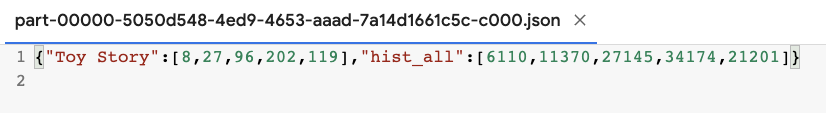

In [22]:
spark.stop()